<a href="https://colab.research.google.com/github/raymondkl92/wqu_capstone_vxx/blob/main/Capstone_P.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#pip install yfinance

In [60]:
import yfinance as yf
import matplotlib.pyplot as plt
import pandas as pd

from datetime import date
from dateutil.relativedelta import relativedelta

end_date = date(2023,6,5) #or date.today()
start_date = end_date - relativedelta(years=2)

In [61]:
spy_price = yf.download("SPY", start=start_date, end=end_date).round(1)[['Adj Close']]
vix_price= yf.download("^VIX", start=start_date, end=end_date).round(1)[['Adj Close']]

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


In [62]:
spy_price.columns=['SPY']
vix_price.columns=['VIX']

In [63]:
df=spy_price.join(vix_price)
df

,SPY,VIX
Date,,
2021-06-07,403.9,16.4
2021-06-08,404.0,17.1
2021-06-09,403.4,17.9
2021-06-10,405.3,16.1
2021-06-11,405.9,15.6
...,...,...
2023-05-26,414.0,18.0
2023-05-30,414.2,17.5
2023-05-31,411.9,17.9


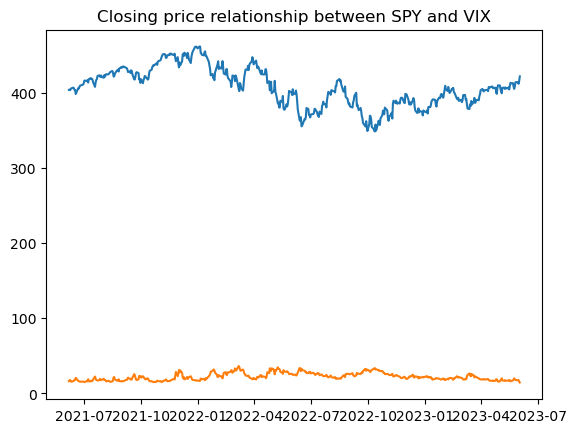

In [64]:
plt.plot(df)
plt.title('Closing price relationship between SPY and VIX')
plt.show()

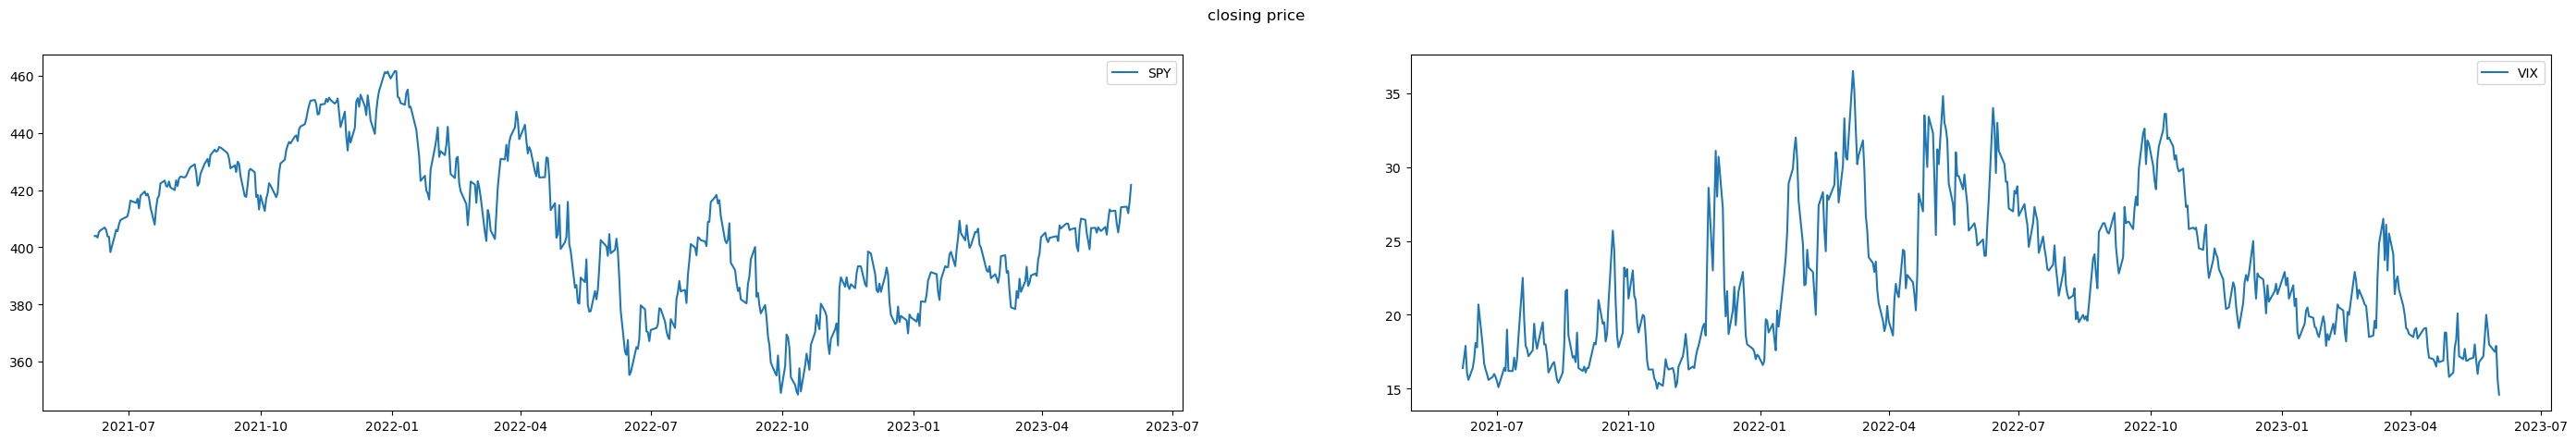

In [65]:
fig,(ax1,ax2) = plt.subplots(1, 2, figsize = (35,5))
fig.suptitle('closing price')
ax1.plot(spy_price, label = 'SPY')
ax2.plot(vix_price, label = 'VIX')
ax1.legend(loc = 'best')
ax2.legend(loc = 'best')

In [66]:
spy_returns = yf.download("SPY", start=start_date, end=end_date).round(1)[['Adj Close']].pct_change().dropna()
vix_returns= yf.download("^VIX", start=start_date, end=end_date).round(1)[['Adj Close']].pct_change().dropna()

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


In [67]:
spy_returns.columns=['SPY']
vix_returns.columns=['VIX']

In [68]:
df=spy_returns.join(vix_returns)
df

,SPY,VIX
Date,,
2021-06-08,0.000248,0.042683
2021-06-09,-0.001485,0.046784
2021-06-10,0.004710,-0.100559
2021-06-11,0.001480,-0.031056
2021-06-14,0.002464,0.051282
...,...,...
2023-05-26,0.012968,-0.057592
2023-05-30,0.000483,-0.027778
2023-05-31,-0.005553,0.022857


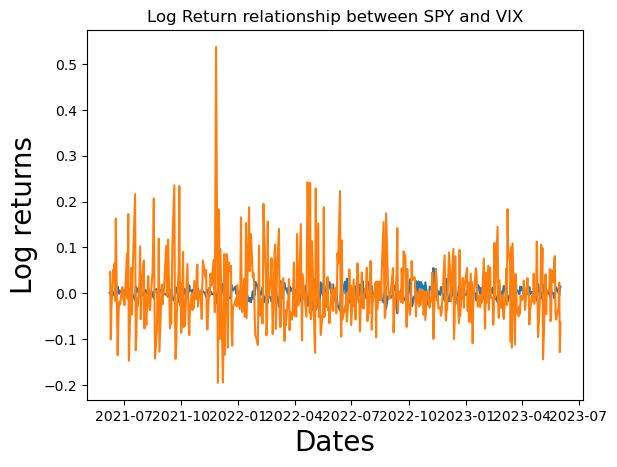

In [69]:
plt.plot(df)
plt.title('Log Return relationship between SPY and VIX')
plt.xlabel('Dates', fontsize=20)
plt.ylabel('Log returns', fontsize=20)
plt.show()

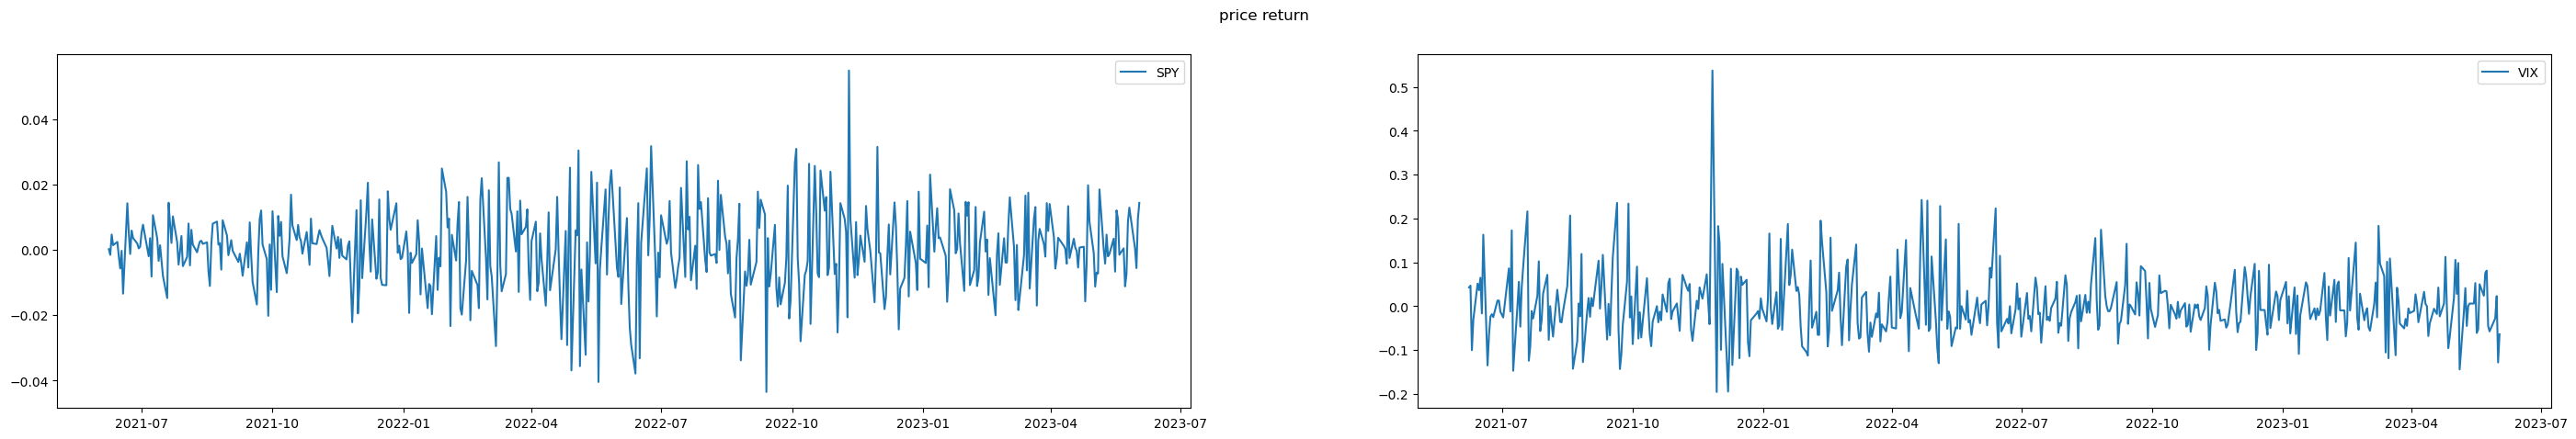

In [70]:
fig,(ax1,ax2) = plt.subplots(1, 2, figsize = (35,5))
fig.suptitle('price return')
ax1.plot(spy_returns, label = 'SPY')
ax2.plot(vix_returns, label = 'VIX')
ax1.legend(loc = 'best')
ax2.legend(loc = 'best')

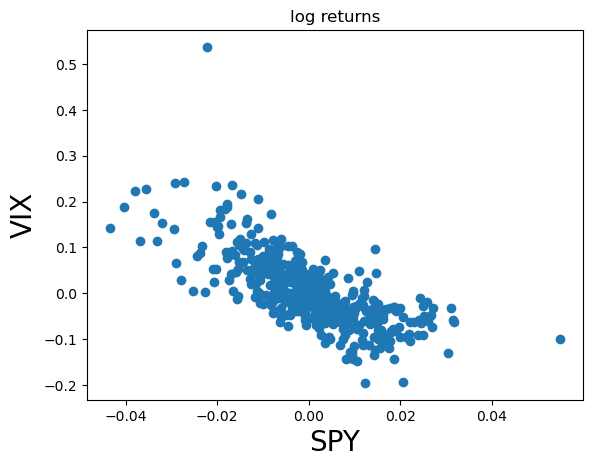

In [71]:
plt.scatter(spy_returns, vix_returns)
plt.title('log returns')
plt.xlabel('SPY', fontsize=20)
plt.ylabel('VIX', fontsize=20)
plt.show()

In [72]:
import statsmodels.api as sm
model = sm.OLS(spy_returns, vix_returns)
results = model.fit()

print(results.summary())

                                 OLS Regression Results                                
Dep. Variable:                    SPY   R-squared (uncentered):                   0.528
Model:                            OLS   Adj. R-squared (uncentered):              0.527
Method:                 Least Squares   F-statistic:                              559.7
Date:                Tue, 30 Apr 2024   Prob (F-statistic):                    1.37e-83
Time:                        13:55:01   Log-Likelihood:                          1677.7
No. Observations:                 501   AIC:                                     -3353.
Df Residuals:                     500   BIC:                                     -3349.
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

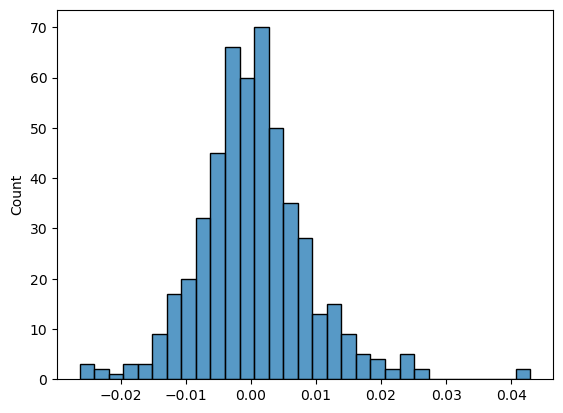

In [73]:
import seaborn as sns
sns.histplot(results.resid);

Since we found the linear regression between the SPY and the VIX then, we found the hedge ratio which compares the value of the position hedge to the size of the entire position.

In [74]:
hedge_ratio = results.params[0]
print("Hedge Ratio: ", hedge_ratio)

Hedge Ratio:  -0.1205054192848763


Our hedge ratio was found to be -0.1205, so we assumed our long position size to be $20000 through which we can use to find our short position size as;

In [75]:
long_position_size = 20000  # value of the long position
short_position_size = -hedge_ratio * long_position_size

print("Long Position Size: ", long_position_size)
print("Short Position Size: ", short_position_size)

Long Position Size:  20000
Short Position Size:  2410.108385697526


We now find our long as well as short returns which guides us through finding hedge and unhedge returns



In [76]:
long_returns = spy_returns
short_returns = -hedge_ratio * vix_returns

# Compute the returns of the hedged and unhedged positions
#hedged_returns = long_returns + short_returns
hedged_returns = long_returns['SPY'] + short_returns['VIX']
hedged_returns = pd.DataFrame(hedged_returns)
unhedged_returns = long_returns

# Compute cumulative returns for the hedged and unhedged positions
hedged_cumulative_returns = (1 + hedged_returns).cumprod() * long_position_size
unhedged_cumulative_returns = (1 + unhedged_returns).cumprod() * long_position_size

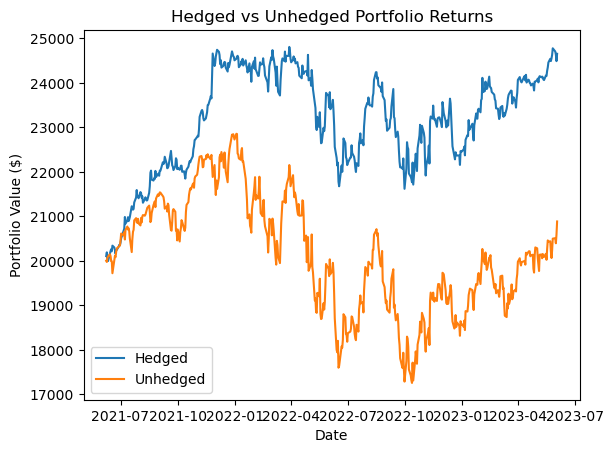

In [77]:
# Plot the cumulative returns
import matplotlib.pyplot as plt

plt.plot(hedged_cumulative_returns, label="Hedged")
plt.plot(unhedged_cumulative_returns, label="Unhedged")
plt.legend()
plt.title("Hedged vs Unhedged Portfolio Returns")
plt.xlabel("Date")
plt.ylabel("Portfolio Value ($)")
plt.show()

Here is the output data gotten such as the mean return, sharp ratio, and standard deviation



In [78]:
import numpy as np

hedged_returns = hedged_returns.dropna()
unhedged_returns = unhedged_returns.dropna()

hedged_mean = np.mean(hedged_returns)
unhedged_mean = np.mean(unhedged_returns)
hedged_std = np.std(hedged_returns)
unhedged_std = np.std(unhedged_returns)

hedged_sharpe_ratio = hedged_mean / hedged_std * np.sqrt(252)
unhedged_sharpe_ratio = unhedged_mean / unhedged_std * np.sqrt(252)

print("Hedged Mean Return: ", hedged_mean)
print("Unhedged Mean Return: ", unhedged_mean)
print("Hedged Standard Deviation: ", hedged_std)
print("Unhedged Standard Deviation: ", unhedged_std)
print("Hedged Sharpe Ratio: ", hedged_sharpe_ratio)
print("Unhedged Sharpe Ratio: ", unhedged_sharpe_ratio)

Hedged Mean Return:  0.0004535736670643878
Unhedged Mean Return:  0.00016317970745838073
Hedged Standard Deviation:  0    0.008489
dtype: float64
Unhedged Standard Deviation:  SPY    0.012374
dtype: float64
Hedged Sharpe Ratio:  0    0.848237
dtype: float64
Unhedged Sharpe Ratio:  SPY    0.209338
dtype: float64


Selected S&P 500 equity with VXX. VXX ETF historical data was obtained from investpy.com

In [79]:
#pip install investpy

### VXX

In [80]:
spy_price = yf.download("SPY", start=start_date, end=end_date).round(1)[['Adj Close']]
vxx_price= yf.download("VXX", start=start_date, end=end_date).round(1)[['Adj Close']]

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


In [81]:
spy_price.columns=['SPY']
vxx_price.columns=['VXX']

In [82]:
df=spy_price.join(vxx_price)
df

,SPY,VXX
Date,,
2021-06-07,403.9,131.2
2021-06-08,404.0,132.6
2021-06-09,403.4,134.7
2021-06-10,405.3,126.9
2021-06-11,405.9,123.3
...,...,...
2023-05-26,414.0,35.7
2023-05-30,414.2,34.7
2023-05-31,411.9,34.5


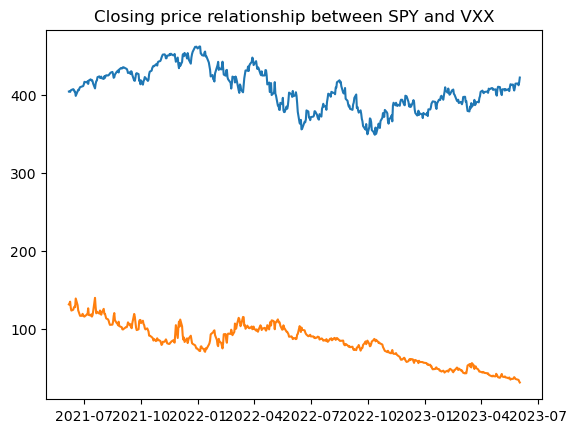

In [83]:
plt.plot(df)
plt.title('Closing price relationship between SPY and VXX')
plt.show()

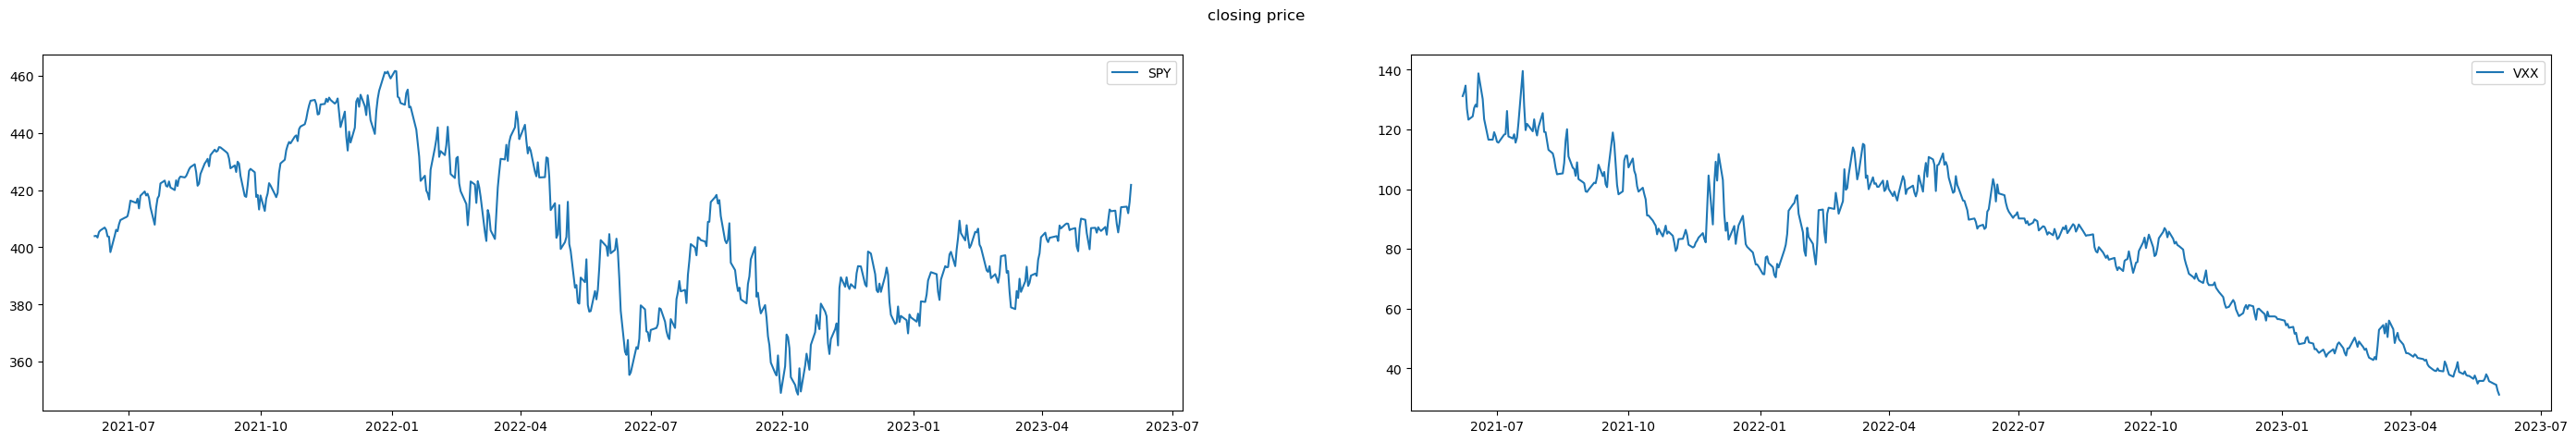

In [84]:
fig,(ax1,ax2) = plt.subplots(1, 2, figsize = (35,5))
fig.suptitle('closing price')
ax1.plot(spy_price, label = 'SPY')
ax2.plot(vxx_price, label = 'VXX')
ax1.legend(loc = 'best')
ax2.legend(loc = 'best')

In [85]:
spy_returns = yf.download("SPY", start=start_date, end=end_date).round(1)[['Adj Close']].pct_change().dropna()
vxx_returns= yf.download("VXX", start=start_date, end=end_date).round(1)[['Adj Close']].pct_change().dropna()

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


In [86]:
spy_returns.columns=['SPY']
vxx_returns.columns=['VXX']

In [87]:
df=spy_returns.join(vxx_returns)
df

,SPY,VXX
Date,,
2021-06-08,0.000248,0.010671
2021-06-09,-0.001485,0.015837
2021-06-10,0.004710,-0.057906
2021-06-11,0.001480,-0.028369
2021-06-14,0.002464,0.008921
...,...,...
2023-05-26,0.012968,-0.037736
2023-05-30,0.000483,-0.028011
2023-05-31,-0.005553,-0.005764


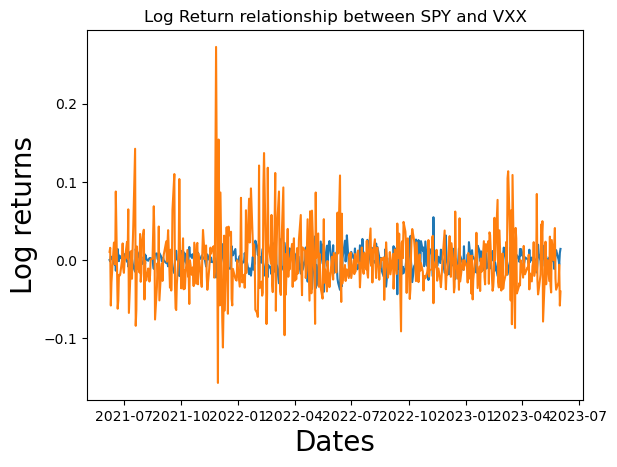

In [88]:
plt.plot(df)
plt.title('Log Return relationship between SPY and VXX')
plt.xlabel('Dates', fontsize=20)
plt.ylabel('Log returns', fontsize=20)
plt.show()

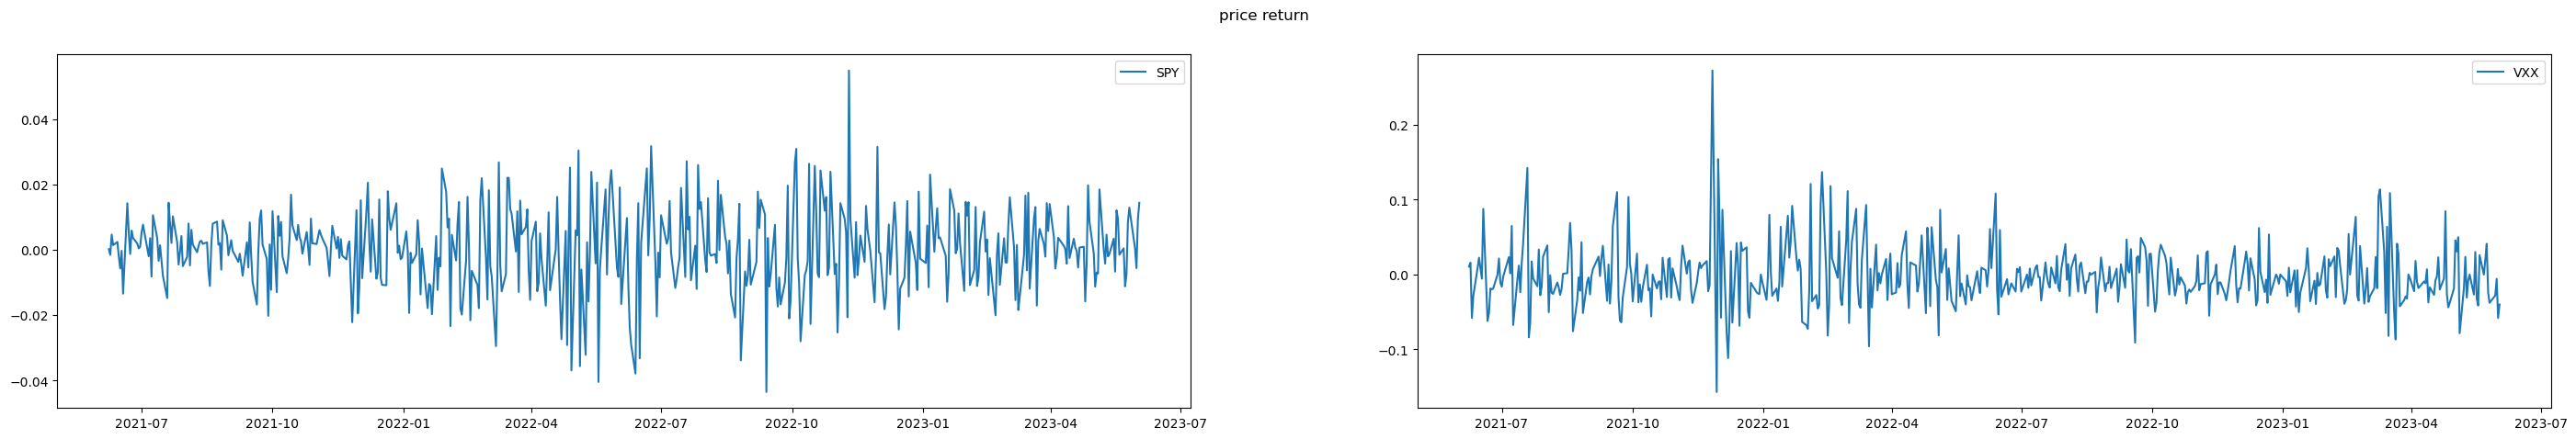

In [89]:
fig,(ax1,ax2) = plt.subplots(1, 2, figsize = (35,5))
fig.suptitle('price return')
ax1.plot(spy_returns, label = 'SPY')
ax2.plot(vxx_returns, label = 'VXX')
ax1.legend(loc = 'best')
ax2.legend(loc = 'best')

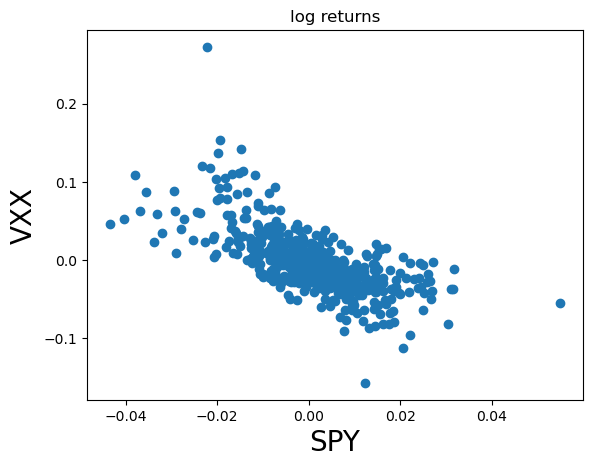

In [90]:
plt.scatter(spy_returns, vxx_returns)
plt.title('log returns')
plt.xlabel('SPY', fontsize=20)
plt.ylabel('VXX', fontsize=20)
plt.show()

In [91]:
import statsmodels.api as sm
model = sm.OLS(spy_returns, vxx_returns)
results = model.fit()

print(results.summary())


                                 OLS Regression Results                                
Dep. Variable:                    SPY   R-squared (uncentered):                   0.458
Model:                            OLS   Adj. R-squared (uncentered):              0.457
Method:                 Least Squares   F-statistic:                              422.6
Date:                Tue, 30 Apr 2024   Prob (F-statistic):                    1.63e-68
Time:                        13:55:50   Log-Likelihood:                          1643.0
No. Observations:                 501   AIC:                                     -3284.
Df Residuals:                     500   BIC:                                     -3280.
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

<Axes: ylabel='Count'>

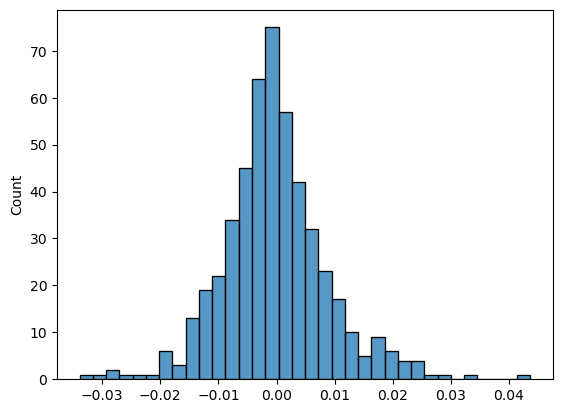

In [92]:
sns.histplot(results.resid)

In [93]:
hedge_ratio = results.params[0]
print("Hedge Ratio: ", hedge_ratio)

Hedge Ratio:  -0.2053146432283442


In [94]:
long_position_size = 20000  # value of the long position
short_position_size = -hedge_ratio * long_position_size

print("Long Position Size: ", long_position_size)
print("Short Position Size: ", short_position_size)

Long Position Size:  20000
Short Position Size:  4106.2928645668835


In [95]:
long_returns = spy_returns
short_returns = -hedge_ratio * vxx_returns

# Compute the returns of the hedged and unhedged positions
#hedged_returns = long_returns + short_returns
hedged_returns = long_returns['SPY'] + short_returns['VXX']
hedged_returns = pd.DataFrame(hedged_returns)
unhedged_returns = long_returns

# Compute cumulative returns for the hedged and unhedged positions
hedged_cumulative_returns = (1 + hedged_returns).cumprod() * long_position_size
unhedged_cumulative_returns = (1 + unhedged_returns).cumprod() * long_position_size

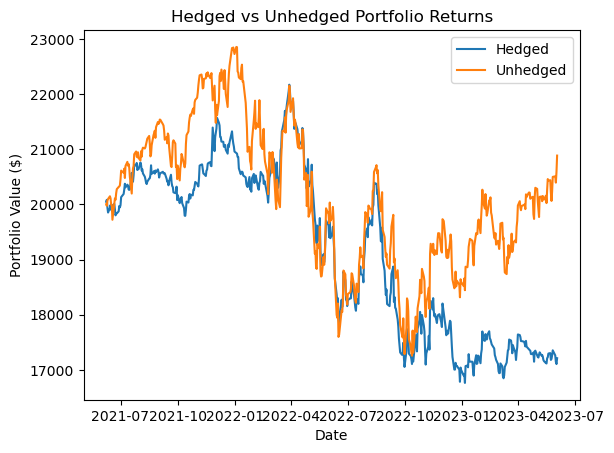

In [96]:
# Plot the cumulative returns

plt.plot(hedged_cumulative_returns, label="Hedged")
plt.plot(unhedged_cumulative_returns, label="Unhedged")
plt.legend()
plt.title("Hedged vs Unhedged Portfolio Returns")
plt.xlabel("Date")
plt.ylabel("Portfolio Value ($)")
plt.show()

In [97]:
hedged_returns = hedged_returns.dropna()
unhedged_returns = unhedged_returns.dropna()

hedged_mean = np.mean(hedged_returns)
unhedged_mean = np.mean(unhedged_returns)
hedged_std = np.std(hedged_returns)
unhedged_std = np.std(unhedged_returns)

hedged_sharpe_ratio = hedged_mean / hedged_std * np.sqrt(252)
unhedged_sharpe_ratio = unhedged_mean / unhedged_std * np.sqrt(252)

print("Hedged Mean Return: ", hedged_mean)
print("Unhedged Mean Return: ", unhedged_mean)
print("Hedged Standard Deviation: ", hedged_std)
print("Unhedged Standard Deviation: ", unhedged_std)
print("Hedged Sharpe Ratio: ", hedged_sharpe_ratio)
print("Unhedged Sharpe Ratio: ", unhedged_sharpe_ratio)

Hedged Mean Return:  -0.00025826284415639137
Unhedged Mean Return:  0.00016317970745838073
Hedged Standard Deviation:  0    0.009107
dtype: float64
Unhedged Standard Deviation:  SPY    0.012374
dtype: float64
Hedged Sharpe Ratio:  0   -0.450192
dtype: float64
Unhedged Sharpe Ratio:  SPY    0.209338
dtype: float64


In [98]:
df=vix_price.join(vxx_price)
df

,VIX,VXX
Date,,
2021-06-07,16.4,131.2
2021-06-08,17.1,132.6
2021-06-09,17.9,134.7
2021-06-10,16.1,126.9
2021-06-11,15.6,123.3
...,...,...
2023-05-26,18.0,35.7
2023-05-30,17.5,34.7
2023-05-31,17.9,34.5


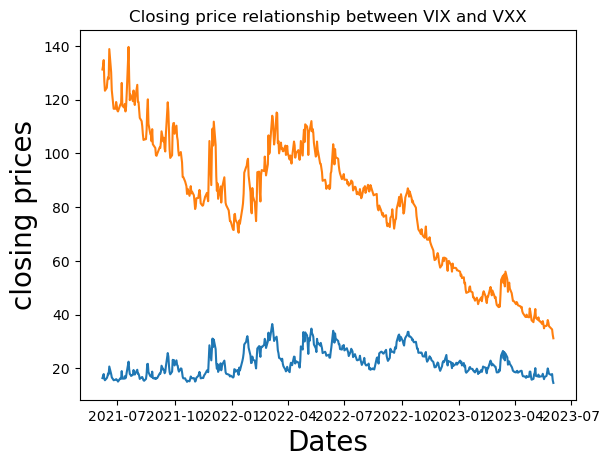

In [99]:
plt.plot(df)
plt.title('Closing price relationship between VIX and VXX')
plt.xlabel('Dates', fontsize=20)
plt.ylabel('closing prices', fontsize=20)
plt.show()

In [100]:
df=vix_returns.join(vxx_returns)
df

,VIX,VXX
Date,,
2021-06-08,0.042683,0.010671
2021-06-09,0.046784,0.015837
2021-06-10,-0.100559,-0.057906
2021-06-11,-0.031056,-0.028369
2021-06-14,0.051282,0.008921
...,...,...
2023-05-26,-0.057592,-0.037736
2023-05-30,-0.027778,-0.028011
2023-05-31,0.022857,-0.005764


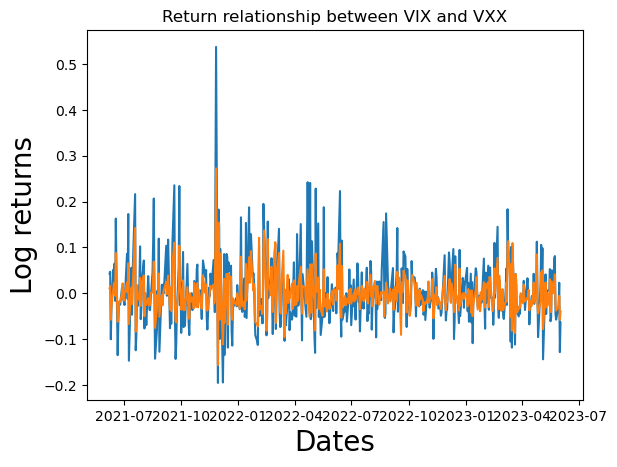

In [101]:
plt.plot(df)
plt.title('Return relationship between VIX and VXX')
plt.xlabel('Dates', fontsize=20)
plt.ylabel('Log returns', fontsize=20)
plt.show()

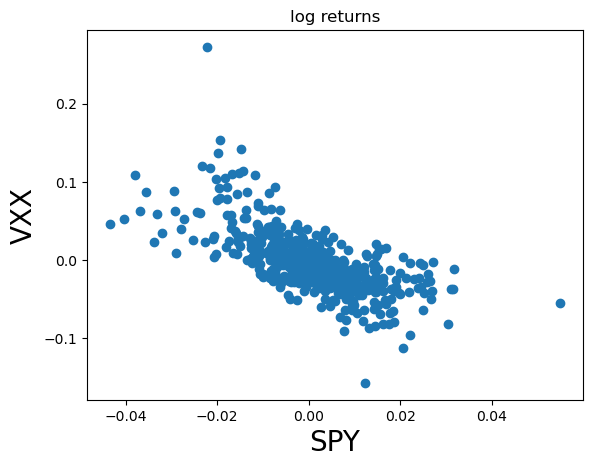

In [102]:
plt.scatter(spy_returns, vxx_returns)
plt.title('log returns')
plt.xlabel('SPY', fontsize=20)
plt.ylabel('VXX', fontsize=20)
plt.show()

## GARCH Model

In [103]:
import numpy as np
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt

# Define the tickers for S&P 500, VIX, and VXX ETF
tickers = ['^GSPC', '^VIX', 'VXX']

# Download historical data from Yahoo Finance
data = yf.download(tickers, start=start_date, end=end_date)


[*********************100%%**********************]  3 of 3 completed


### VIX

/home/saheed/anaconda3/lib/python3.11/site-packages/arch/univariate/base.py:311: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.005181. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


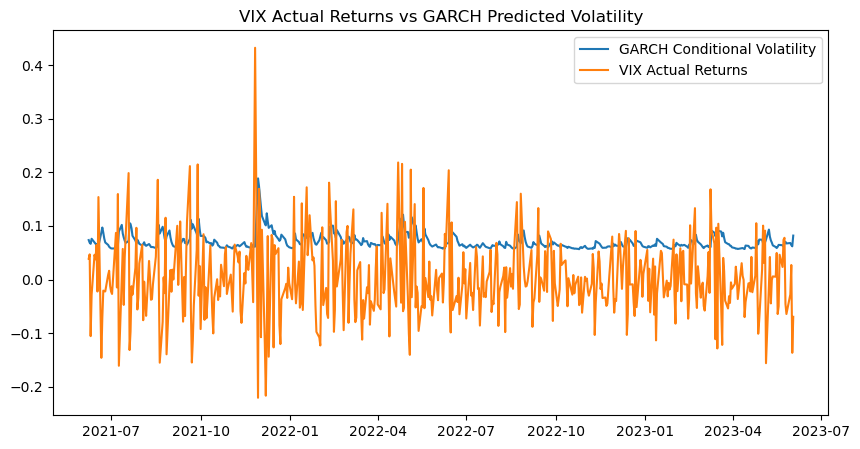

MSE of GARCH model: 0.00013120239998308175
MSE of Regression model: 0.0023507895291127066


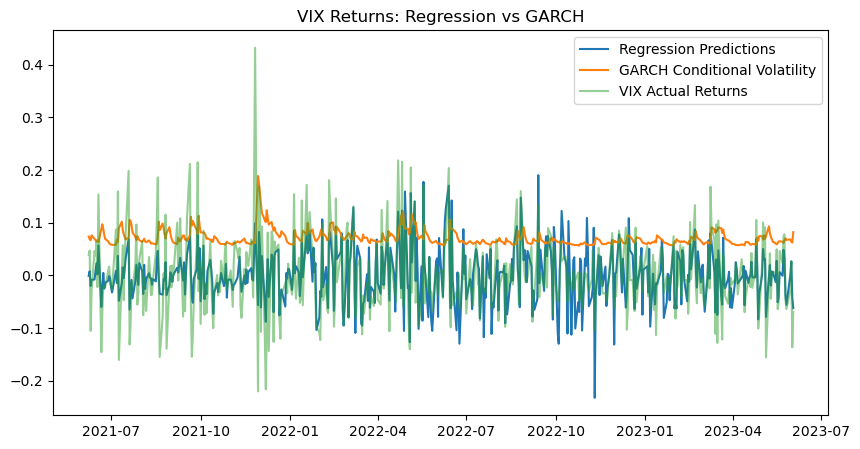

In [104]:
#pip install arch
from arch import arch_model
import statsmodels.api as sm

# Calculate daily returns as Log returns
log_returns = np.log(data['Adj Close']).diff().dropna()

# Fit a GARCH(1,1) model to the VIX
garch_vix = arch_model(log_returns['^VIX'], vol='GARCH', p=1, q=1)
res_garch_vix = garch_vix.fit(update_freq=5, disp='off')

# Create GARCH model prediction for the next time step
forecasts = res_garch_vix.forecast(horizon=1, align='origin')

# Plot the VIX actual vs predicted conditional volatility
plt.figure(figsize=(10, 5))
plt.plot(log_returns.index, res_garch_vix.conditional_volatility, label='GARCH Conditional Volatility')
plt.plot(log_returns.index, log_returns['^VIX'], label='VIX Actual Returns')
plt.title('VIX Actual Returns vs GARCH Predicted Volatility')
plt.legend()
plt.show()

# Fit a simple Linear regression model for the S&P 500 predicting VIX returns
X = sm.add_constant(log_returns['^GSPC'])
model = sm.OLS(log_returns['^VIX'], X)
model = model.fit()

# Predictions from the Linear regression model
regression_predictions = model.predict(X)

# Compare the regression model's performance to the GARCH model's performance
# We'll use Mean Squared Error (MSE) as the metric
mse_garch = np.mean(np.square(forecasts.variance.values[-1, :] - log_returns['^VIX']**2))
mse_regression = np.mean(np.square(regression_predictions - log_returns['^VIX']))

print(f'MSE of GARCH model: {mse_garch}')
print(f'MSE of Regression model: {mse_regression}')

# Compare visually the performance of GARCH vs Regression model for VIX returns
plt.figure(figsize=(10, 5))
plt.plot(log_returns.index, regression_predictions, label='Regression Predictions')
plt.plot(log_returns.index, res_garch_vix.conditional_volatility, label='GARCH Conditional Volatility')
plt.plot(log_returns.index, log_returns['^VIX'], label='VIX Actual Returns', alpha=0.5)
plt.title('VIX Returns: Regression vs GARCH')
plt.legend()
plt.show()

### VXX

/home/saheed/anaconda3/lib/python3.11/site-packages/arch/univariate/base.py:311: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.001607. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


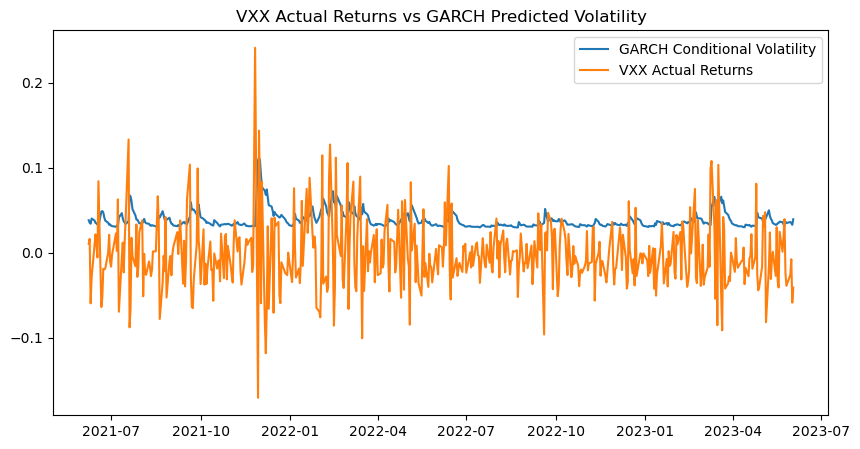

MSE of GARCH model: 1.4542944956539221e-05
MSE of Regression model: 0.0008505856923154697


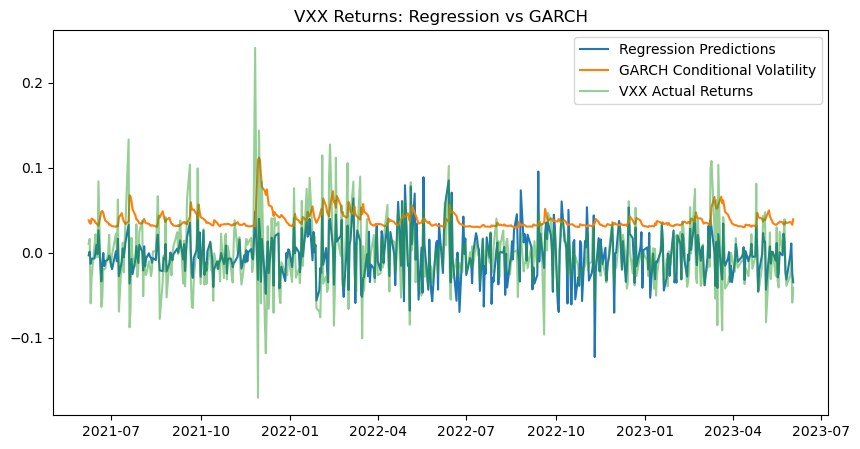

In [105]:
# Calculate daily returns as Log returns
log_returns = np.log(data['Adj Close']).diff().dropna()

# Fit a GARCH(1,1) model to the VXX
garch_VXX = arch_model(log_returns['VXX'], vol='GARCH', p=1, q=1)
res_garch_VXX = garch_VXX.fit(update_freq=5, disp='off')

# Create GARCH model prediction for the next time step
forecasts = res_garch_VXX.forecast(horizon=1, align='origin')

# Plot the VXX actual vs predicted conditional volatility
plt.figure(figsize=(10, 5))
plt.plot(log_returns.index, res_garch_VXX.conditional_volatility, label='GARCH Conditional Volatility')
plt.plot(log_returns.index, log_returns['VXX'], label='VXX Actual Returns')
plt.title('VXX Actual Returns vs GARCH Predicted Volatility')
plt.legend()
plt.show()

# Fit a simple Linear regression model for the S&P 500 predicting VXX returns
X = sm.add_constant(log_returns['^GSPC'])
model = sm.OLS(log_returns['VXX'], X)
model = model.fit()

# Predictions from the Linear regression model
regression_predictions = model.predict(X)

# Compare the regression model's performance to the GARCH model's performance
# We'll use Mean Squared Error (MSE) as the metric
mse_garch = np.mean(np.square(forecasts.variance.values[-1, :] - log_returns['VXX']**2))
mse_regression = np.mean(np.square(regression_predictions - log_returns['VXX']))

print(f'MSE of GARCH model: {mse_garch}')
print(f'MSE of Regression model: {mse_regression}')

# Compare visually the performance of GARCH vs Regression model for VXX returns
plt.figure(figsize=(10, 5))
plt.plot(log_returns.index, regression_predictions, label='Regression Predictions')
plt.plot(log_returns.index, res_garch_VXX.conditional_volatility, label='GARCH Conditional Volatility')
plt.plot(log_returns.index, log_returns['VXX'], label='VXX Actual Returns', alpha=0.5)
plt.title('VXX Returns: Regression vs GARCH')
plt.legend()
plt.show()